# Overview

In [77]:
import os, importlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt

import eda
import data_preparation as dpre
import data_processing as pro
import visualize as vis

import shutil

# a small piece of code to find the data folder
NOTEBOOK_SCRIPT = os.getcwd()

DATA_FOLDER = os.path.join(NOTEBOOK_SCRIPT, 'data')
os.makedirs(DATA_FOLDER,exist_ok=True)

if os.path.exists(os.path.join(NOTEBOOK_SCRIPT, 'F24.ML.Assignment.One.data.db')):
	shutil.move(os.path.join(NOTEBOOK_SCRIPT, 'F24.ML.Assignment.One.data.db'), os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db'))

import warnings
warnings.filterwarnings("ignore")

In [ ]:
db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
           df_save_file, 
           overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
           )
df.head()

# Data Preparation

## Whole-dataset preparation
Before proceeding with the train-split procedure, it is necessary to apply few operations on the entire dataset: 

* compute the labels
* sanity check: no samples have a negative label
* remove few problematic samples (with prep time equal to 0)
* remove samples with `planned_prep_time` missing 

The data has been prepared (with SQL) such that for a single order neither `finish_prep_date` nor `start_prep_date` would be missing and the natural relation `finish_prep_date` > `start_prep_date` is preserved. The label for a given order is the difference of these two values and hence a missing value in one of them would mean a missing label. 

Imputing missing labels is highly discouraged as it is likely to introduce bias according to the first chapter of [Multivariate Analysis](https://www.drnishikantjha.com/papersCollection/Multivariate%20Data%20Analysis.pdf). 

Since `planned_prep_time` is intuitively a very good indicator of the actual preparation time, we will also remove the very few samples with missing `planned_prep_time`. 

In [ ]:
np.mean(df.isna(), axis=0)

In [ ]:
all_data_regression = dpre.prepare_all_data_regression(df)
all_data_regression

## Split Data

The samples contains both order-level and item-level features. The samples belonging to the same order share most of the features and most importantly the label.

Hence data splitting should take this information into account and split the data by order_id. In other words, the train and test splits must have disjoint set of orders (order_ids)

In [ ]:
# according to the assignment requirements, the data must be split into train and test with test representing 10% of the data
importlib.reload(dpre)
df_train, df_test = dpre.df_split_regression(all_data_regression, splits=(0.9, 0.1))
# everything seems to checkout !!!
len(df_train), len(df_test), round(len(df_train) / len(df_test), 4) 

In [ ]:
df_train.nunique()

## Impute Missing data:  The price and profit columns 

### Price Feature Imputation
Let's start with the idea. It seems reasonable to assume that a product would relatively close values. If we're lucky we can estimate the price of a product, by the aggregation of prices of other instances of the same product. 
if some prices are still missing we will just impute them with the median

### Profit 
Unlik the price feature, the profit is computed across the entire order. Considering every combination of store_id and product_id, the `min` statistics is the tightest estimation for the profit a store makes on a product.
why ? simply because orders can have multiple products and hence the `profit` on the entire order is at least as large as that on a single product. the `min` statistics is the truth value for any product that has been purchased as a single product at least once.

In [45]:
# impute the price and profit columns
importlib.reload(pro)
df_train, df_test = pro.impute_prices(df_train, df_test)
df_train, df_test = pro.impute_price_with_median(df_train, df_test)
df_train, df_test = pro.impute_profit(df_train, df_test)

In [ ]:
df_train.isna().sum(), df_test.isna().sum()

# EDA

## Labels: preparation time

In [ ]:
# let's visualize the distribution of labels: both box plot and histograms

y_train_by_order_df = pd.pivot_table(df_train, index='order_id', values='y', aggfunc='mean').iloc[:, 0]
vis.visualize_continuous_distribution(y_train_by_order_df, sequence_name='actual prep time')

The histogram clearly demonstrates the skewed distribution of preparation time. Furthermore, the box plot confirms the presence of a relatively large number of outliers. 

In [ ]:
# let's remove outliers using the iqr outliers detection techniques and plot the distribution again
min_y, max_y = eda.compute_iqr_limiters(y_train_by_order_df)
y_filtered = y_train_by_order_df[y_train_by_order_df.between(min_y, max_y)]
vis.visualize_continuous_distribution(y_filtered, "actual prep time (no outliers)")

The two visualizations above clearly demonstrate the significant of outliers on data distribution. Therefore, it seems reasonable to remove such samples. However, The only concern here is data loss: How much data would we lose ?

In [ ]:
mask = y_train_by_order_df.between(min_y, max_y)
print(np.mean(mask)) # less than 2% of the data... we can live with that...

# remove the outliers
eda.iqr_outliers(df_train, column='y', add_column=True)
df_train = df_train[df_train['y_is_outlier'] == False]
df_train.drop(columns='y_is_outlier', inplace=True)

## Order Created date

Order Created date by itself does not add much value. However, a large time difference between the time an order was created and started might reflect unusual difficulties in the store / restaurant. Let's see if this hypothesis holds

In [ ]:

# the order created feature by itself does not add much value. However, the difference etween order_created_date and order_prep_date might be useful
df_train_unique  = df_train.drop_duplicates(subset=['order_id'])
df_train_unique = df_train_unique[~df_train_unique['order_created_date'].isna()]
# the next step is to get shit out of the way
df_train_unique['delay'] = (df_train_unique['start_prep_date'] - df_train_unique['order_created_date']).dt.total_seconds()

vis.visualize_continuous_distribution(df_train_unique['delay'], sequence_name="order start prep time delay")

In [ ]:
d = df_train_unique['delay']
min_d, max_d = eda.compute_iqr_limiters(d)
print("Min and Max delays:", min_d, max_d)
print("portion of outlier delays: ", round((~d.between(min_d, max_d)).mean(), 4))

In [ ]:
# let's see if a large delay affects the target or the difference between planned time and the targetd\
df_train_unique['deviation'] = df_train_unique['y'] - df_train['planned_prep_time']
df_train_unique.loc[:, ['deviation', 'delay', 'y']].corr()

## Discrete Features

In [ ]:
import visualize as vis
importlib.reload(vis)
vis.visualize_discrete_values(df_train, feat_col="product_id", label_col='y', label_name='actual prep time', n_most_freq=20)

In [ ]:
vis.visualize_discrete_values(df_train, feat_col="store_id", label_col='y', label_name='actual prep time', n_most_freq=20)

The box plots perfectly illustrate the `store_id` and `product_id` (at least the top most frequent ones) have different target distributions and should be somehow encoded into the inputs of ML models.

## Continuous features 

In [14]:
import data_processing as pro
df_train, df_test = pro.impute_prices(df_train, df_test)

# impute the missing price samples with median
df_train, df_test = pro.impute_price_with_median(df_train, df_test)

# there should be non missing values from now on 
df_train, df_test = pro.impute_profit(df_train, df_test)

In [ ]:
numerical_feats = ['profit', 'price', 'delivery_distance', 'planned_prep_time', 'y']
# let's see the effect of outliers

profit_outliers = eda.compute_iqr_limiters(df_train['profit'])
price_outliers = eda.compute_iqr_limiters(df_train['price'])
del_distance_outliers =eda.compute_iqr_limiters(df_train['delivery_distance'])

profit_outliers, price_outliers, del_distance_outliers

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(22, 12))

profit_all = df_train['profit'] 
profit_filtered = df_train[df_train['profit'].between(profit_outliers[0], profit_outliers[1])]['profit']

del_distance_all = df_train['delivery_distance'] 
del_distance_filtered = df_train[df_train['delivery_distance'].between(del_distance_outliers[0], del_distance_outliers[1])]['delivery_distance']

price_all = df_train['price'] 
price_filtered = df_train[df_train['price'].between(price_outliers[0], price_outliers[1])]['price']

sns.histplot(data=profit_all,ax=axes[0, 0])
axes[0, 0].set_title('profit')
sns.histplot(data=profit_filtered,ax=axes[0, 1])
axes[0, 1].set_title('profit filtered')


sns.histplot(data=del_distance_all,ax=axes[1, 0])
axes[1, 0].set_title('delivery distance')
sns.histplot(data=del_distance_filtered,ax=axes[1, 1])
axes[1, 1].set_title('delivery distance filtered')

sns.histplot(data=price_all, ax=axes[2, 0])
axes[2, 0].set_title('price')
sns.histplot(data=price_filtered,ax=axes[2, 1])
axes[2, 1].set_title('price filtered')

plt.show()


In [19]:
# let's create a new variable that represents whether a certain sample in an outlier with respect to the distribution of the continuous features
importlib.reload(vis)
feats = ['profit', 'price', 'delivery_distance']
feats_extremes = [eda.compute_iqr_limiters(x=df_train[f]) for f in feats]
for f, fext in zip(feats, feats_extremes):
	df_train[f'{f}_is_outlier'] = (~df_train[f].between(fext[0], fext[1])).astype(int)
	

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(12, 12))
for f_index, (f, fext) in enumerate(zip(feats, feats_extremes)):
	f1, f2 = df_train[df_train[f'{f}_is_outlier'] == True][f], df_train[df_train[f'{f}_is_outlier'] == False][f] 
	y1, y2 = df_train[df_train[f'{f}_is_outlier'] == True]["y"], df_train[df_train[f'{f}_is_outlier'] == False]["y"], 

	f1 = f1.sort_values()
	f2 = f2.sort_values()

	axes[f_index, 0].scatter(f1, y1)
	axes[f_index, 1].scatter(f2, y2)

	axes[f_index, 0].set_title(f"{f} outliers")
	axes[f_index, 1].set_title(f"{f} non-outliers")

plt.show()

In [ ]:
importlib.reload(vis)
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(12, 12))
for f_index, f in enumerate(feats):
	vis.visualize_discrete_values(df_train, 
							   feat_col=f'{f}_is_outlier', 
							   label_col='y', 
							   axes=axes[f_index], 
							   show=False, 
							   n_most_freq=None)
plt.show()

* outliers removal
* price imputation
* profit imputation
* product_id encoding
* store_id encoding
* time features
* features scaling


## Feature clasification: Encoding categorical features


Before applying feature enginnering techniques, it is important to understand the type of data we have: categorial, numerical...

The features can be classified as follows:

1. Categorical: 
	* product_id
	* store_id
	* order_id: if the product_id does not make a difference, then we will use group by the order id and reduce the number of samples...

2. Continuous:
	* planned prep time
	* price

3. time:
	* start_prep_time: extract the day of the week, the hour, the number of orders a store has received in the last "x" minutes
	* product creation time

Few observations: 

* too many products
* either discard products in general (if most of them were ordered only once or twice) or somehow laverage the frequntly ordered products
* we have few stores which means we can build some 
* the price needs to aggregated across all items in the order


# Product Ids: 
too many products, consider only the $n$ most frequent products where $n$ represent the number of products that cover $70\%$ of all orders. Out of 55k unique products, $n$ turns out to be aroun 6k: almost $10\%$. Any product id that does belong to this set was set to $-1$ as an id. This is just an intermediate step as the product ids were further encoded using the target encoder implemented by SKlearn. Although I experimented with some  custom encoding ideas of mine, The battle-test Target encoder led to better results

### Store id

We more 1.4k unique stores. One way to fully laverage the store_id is to better understand the deviation between the (actual preparation time) and the planned preparation time. For each store, calculate the average difference between the planned time and the actual preparation time along with std. Then For each store id we compute an estimation with 2 different upper and lower bound. 

For each store id, I compute $\mu$ and $\sigma$ from the training data (unpopular stores are associated with mean and std aggregated across all unpopular stores). For each store id and order id combination, 

I compute `planned prep time` + $\mu$, `planned prep time` + $\mu$ $\pm$ $\sigma$,   `planned prep time` + $\mu$ $\pm$ $2 \cdot \sigma$

# Train Data Final Form

All we have done so far revolved around preparing the features: mainly imputing as much of the `price` and `profit` features and trying to embed as much information in the encoding of the `store_id` and `product_id` features.

The final processing step is to group the orders as follows:

* sum up the price of each product producing the total order price
* choosing the encoding of the most frequent product in the orer

In [78]:
importlib.reload(pro)
# let's see the correlation matrix after the processing
db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
org_data = dpre.data_to_df(db_file, 
		df_save_file, 
		overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
		)

# # the regression task
all_data_regression = dpre.prepare_all_data_regression(org_data)
train, test = dpre.df_split_regression(all_data_regression, splits=(0.9, 0.1))

# process without polynomial features
df_train_simple, df_test_simple = pro.process_data_regression(train, test, 
                                                              poly_feats=False, 
                                                              scale=False) # setting scale to False just to visualize the correlation for now.

zero prep time portion:  0.00115958265972316
ratio of samples with missing `planned_prep_time`: 3.65359198328847e-06


<Axes: >

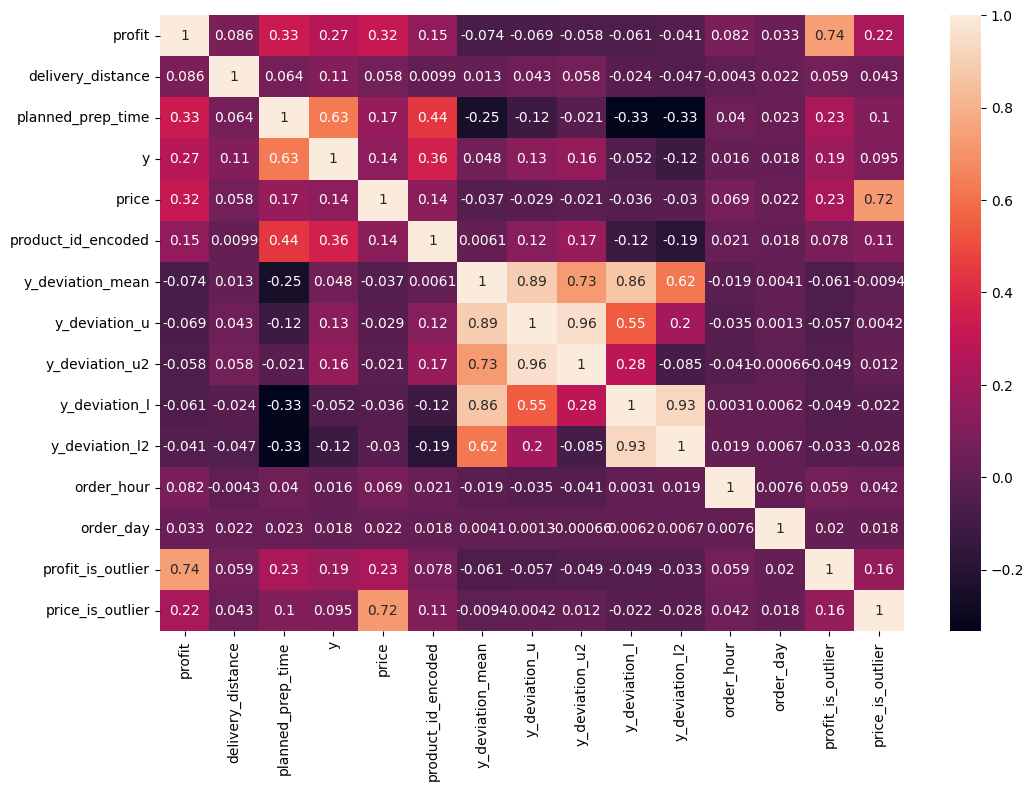

In [83]:
import seaborn as sns
fig = plt.figure(figsize=(12, 8))
sns.heatmap(df_train_simple.corr(), annot=True)

We can see that `y` has an overall low correlation with the features. However, the correlation between `y` and the `product_id`, `profit` and `planned prep time` are relatively high, displaying some positive results out of the extensive processing.

# Regression Models

In [ ]:
# call a function that will prepare the different formats of the data regression with and without poly features, classification with / out poly features
importlib.reload(pro)
pro.set_up()

In [27]:
df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'train_simple.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'y_train_simple.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'test_simple.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'y_test_simple.csv')).squeeze()

In [ ]:
import models
importlib.reload(models)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr, lr1, lr2 = LinearRegression(), Lasso(alpha=1), Ridge(alpha=1), 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train, y_train, df_test, y_test, m, task='regression')
	print(m_name, models_res[m_name][1:])

In [30]:
from sklearn.tree import DecisionTreeRegressor
DecReg = DecisionTreeRegressor(max_depth=4, random_state=0)
models_res[models._extract_model_name_from_cls(DecReg)] = models.pipeline(df_train, y_train, df_test, y_test, DecReg, task='regression')


In [ ]:
models_res[models._extract_model_name_from_cls(DecisionTreeRegressor())]

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=4)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train, y_train, df_test, y_test, rf, task='regression')

In [ ]:
models_res[models._extract_model_name_from_cls(RandomForestRegressor())]

In [34]:
df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'train_poly.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'y_train_poly.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'test_poly.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'regression', 'y_test_poly.csv')).squeeze()

In [ ]:
import models
importlib.reload(models)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr, lr1, lr2 = LinearRegression(), Lasso(alpha=1, max_iter=1000), Ridge(alpha=1, max_iter=100), 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train, y_train, df_test, y_test, m, task='regression')
	print(m_name, models_res[m_name][1:])

In [37]:
from sklearn.tree import DecisionTreeRegressor
DecReg = DecisionTreeRegressor(max_depth=4, random_state=0)
models_res[models._extract_model_name_from_cls(DecReg)] = models.pipeline(df_train, y_train, df_test, y_test, DecReg, task='regression')

In [ ]:
models_res[models._extract_model_name_from_cls(DecReg)] 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=4)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train, y_train, df_test, y_test, rf, task='regression')

# Classification

In [ ]:
import data_preparation as dpre
importlib.reload(dpre)
db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
org_data = dpre.data_to_df(db_file, 
		df_save_file, 
		overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
		)

all_data_classification = dpre.prepare_all_data_classification(org_data)

# split the data
df_train, df_test = dpre.df_split_classification(all_data_classification, splits=(0.9, 0.1))

print(len(df_train), len(df_test), round(len(df_train) / len(df_test), 4))

print(df_train['y_cls'].value_counts())
print(df_test['y_cls'].value_counts())

df_train = df_train.drop(columns='y').rename(columns={"y_cls": "y"})
df_test = df_test.drop(columns='y').rename(columns={"y_cls": "y"})

In [ ]:
d = df_train[~df_train['order_created_date'].isna()]
d.loc[:, ['delay']] = (d['start_prep_date'] - d['order_created_date']).dt.total_seconds()

min_d, max_d = eda.compute_iqr_limiters(d['delay'])
d.loc[: ,['delay_is_outlier']] = (~d['delay'].between(min_d, max_d)).astype(int)

print(f"portion of outlier delays: {d['delay_is_outlier'].mean()}")
print(f"distribution of classes for orders with and without delays respectively: {d[d['delay_is_outlier']==True]['y'].mean()}, {d[d['delay_is_outlier']==False]['y'].mean()}")

print(f"correlation between delays and on time preparation: {np.corrcoef(d['delay_is_outlier'], d['y'])}")

In [ ]:
importlib.reload(pro)
all_data_classification = dpre.prepare_all_data_classification(org_data)
# split the data
df_train, df_test = dpre.df_split_classification(all_data_classification, splits=(0.9, 0.1))
# process
df_train, df_test = pro.process_data_classification(df_train, df_test)

In [ ]:
df_train.isna().sum(), df_test.isna().sum()

# Classification Models

## Initial Features

In [41]:
import pandas as pd

df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'train_simple.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_train_simple.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'test_simple.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_test_simple.csv')).squeeze()

In [ ]:
import models
import importlib
importlib.reload(models)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lr, lr1, lr2 = (LogisticRegression(penalty=None, random_state=0, max_iter=1000), 
				LogisticRegression(penalty='l1', solver='saga', random_state=0, max_iter=1000), 
				LogisticRegression(penalty='l2', random_state=0, C=0.5, max_iter=1000)
				) 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train, y_train, df_test, y_test, m, task='classification')
	print(m_name, models_res[m_name][1:])

In [8]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=6, random_state=0)
models_res[models._extract_model_name_from_cls(dtc)] = models.pipeline(df_train, y_train, df_test, y_test, dtc, task='classification')

In [ ]:
models_res[models._extract_model_name_from_cls(dtc)]

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=6)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train, y_train, df_test, y_test, rf, task='classification')

In [ ]:
models_res[models._extract_model_name_from_cls(rf)]

### Polynomial Features

In [43]:
import pandas as pd

df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'train_poly.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_train_poly.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'test_poly.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_test_poly.csv')).squeeze()

In [ ]:
import models
import importlib
importlib.reload(models)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lr, lr1, lr2 = (LogisticRegression(penalty=None, random_state=0, max_iter=1000), 
				LogisticRegression(penalty='l1', solver='saga', random_state=0, max_iter=1000), 
				LogisticRegression(penalty='l2', random_state=0, C=0.5, max_iter=1000)
				) 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train, y_train, df_test, y_test, m, task='classification')
	print(m_name, models_res[m_name][1:])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=6, random_state=0)
models_res[models._extract_model_name_from_cls(dtc)] = models.pipeline(df_train, y_train, df_test, y_test, dtc, task='classification')

In [ ]:
models_res[models._extract_model_name_from_cls(dtc)]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=6)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train, y_train, df_test, y_test, rf, task='classification')

In [ ]:
models_res[models._extract_model_name_from_cls(rf)]

## Hyperparameter Tuning

In [45]:
df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'train_simple.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_train_simple.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'test_simple.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'classification', 'y_test_simple.csv')).squeeze()

In [58]:
# save the object
import pickle
def save_tuned_model(model):
	model_name = models._extract_model_name_from_cls(model)
	save_dir = os.path.join(DATA_FOLDER, 'models', "classification", f'{model_name}_tuned')        
	os.makedirs(save_dir, exist_ok=True)
	save_model_path = os.path.join(save_dir, f'{model_name}_tuned.ob')
	with open(save_model_path, 'wb') as f:
		pickle.dump(model, f)

def load_tuned_model(model):
	model_name = models._extract_model_name_from_cls(model)
	save_dir = os.path.join(DATA_FOLDER, 'models', "classification", f'{model_name}_tuned')        
	save_model_path = os.path.join(save_dir, f'{model_name}_tuned.ob')

	with open(save_model_path, 'rb') as f:
		model = pickle.load(f)
	return model

In [60]:
import models
importlib.reload(models)
from sklearn.metrics import accuracy_score

lr_grid = {"C": np.logspace(start=-1, stop=1, base=10)}
lr_tuned = models.tune(model=LogisticRegression(random_state=0, max_iter=1000), 
                       param_grid=lr_grid, 
                       X_train=df_train, 
                       y_train=y_train, 
                       score="accuracy",
                       strategy='random')

save_tuned_model(lr_tuned)

In [ ]:
lr_tuned = load_tuned_model(LogisticRegression())
models.evaluate_classification_model(df_test, y_test, lr_tuned, )

In [62]:
rf_grid = {"max_depth":[4, 5, 6, 7], "min_samples_split": np.linspace(0.05, 0.2), "min_samples_leaf": np.logspace(start=-2, stop=-1,base=10)}
rf_ = RandomForestClassifier(random_state=0, n_estimators=200)
rf_tuned = models.tune(model=rf_, 
                       param_grid=rf_grid, 
                       X_train=df_train, 
                       y_train=y_train, 
                       score='accuracy',
                       strategy='random')

# save the model
save_tuned_model(rf_tuned)

In [ ]:
rf_tuned = load_tuned_model(RandomForestClassifier())
models.evaluate_classification_model(df_test, y_test, rf_tuned)